# 最终预测(只进行一次建模的情况）

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf
from tensorflow.python.keras.models import Sequential, Model
from tensorflow.python.keras.layers import Dense, LSTM, Dropout, Attention, AdditiveAttention, Layer, Input, RepeatVector
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_log_error, r2_score
import keras.backend as K
import matplotlib
# 让绘图时显示中文
matplotlib.rc("font",family='MicroSoft YaHei',weight="bold")


In [2]:
# 最终模型初始参数
time_step = 2
units = 150
activation = 'relu'
optimizer = 'adam'
dropout = 0.3

In [3]:
index = pd.read_csv('pack_data.csv')


In [4]:
# 导入数据集
index = pd.read_csv('pack_data.csv')

data = index
data['Date']=pd.to_datetime(data['Date'],format='%Y-%m ')
# 数据初步分组
data = np.array(data)
# 划分训练集和测试集
data_train = data[:168] #训练集,2008年-2021年的数据，共1168个
data_train_time = data_train[:,0]   #训练集时间标签
data_train_pack = data_train[:,1]   #训练集数据
data_test = data[168:192]  #测试集,22, 23数据，共24个
data_test_time = data_test[:,0] #测试集时间标签
data_test_pack = data_test[:,1] #
data_predict = data[192:]    #预测集,2024年数据，共12个
data_predict_time = data_predict[:,0]
data_predict_pack = data_predict[:,1]
# 数据归一化（时间标签不需要）
scaler = MinMaxScaler(feature_range=(0,1))
data_train_pack = scaler.fit_transform(data_train_pack.reshape(-1,1))
data_test_pack = scaler.transform(data_test_pack.reshape(-1,1))
data_predict_pack = scaler.transform(data_predict_pack.reshape(-1,1))
# 分离特征和目标
train_x, test_x, predict_x = data_train_pack[:,0], data_test_pack[:,0], data_predict_pack[:,0]

In [5]:
# 数据重塑 创建自定义时间步长的数据集
def create_dataset(x, time_step):
    xs, ys = [], []
    for i in range(len(x) - time_step):
        v = x[i:(i + time_step)]
        xs.append(v)
        ys.append(x[i + time_step])
    return np.array(xs), np.array(ys)
# 数据重塑
train_xs, train_ys = create_dataset(train_x, time_step)
test_xs, test_ys = create_dataset(test_x, time_step)
predict_xs, predict_ys = create_dataset(predict_x, time_step)
# 调整数据形状，调整后的三维形状为(samples, time steps, features)，即数据集中总共有sample个数据，每个数据有time steps个时间步长，每个时间步长有features个特征。
train_xs = train_xs.reshape(train_xs.shape[0],train_xs.shape[1],1)
test_xs = test_xs.reshape(test_xs.shape[0],test_xs.shape[1],1)
predict_xs = predict_xs.reshape(predict_xs.shape[0],predict_xs.shape[1],1)


In [6]:
# 自定义时间注意力机制
class TimeAttention(Layer):
    def __init__(self, time_step,
                 W_regularizer=None, b_regularizer=None,
                 W_constraint=None, b_constraint=None,
                 bias=True, **kwargs):
        self.supports_masking = True
        self.init = tf.keras.initializers.get('glorot_uniform')
        # W_regularizer: 权重上的正则化
        # b_regularizer: 偏置项的正则化
        self.W_regularizer = tf.keras.regularizers.get(W_regularizer)
        self.b_regularizer = tf.keras.regularizers.get(b_regularizer)
        # W_constraint: 权重上的约束项
        # b_constraint: 偏置上的约束项
        self.W_constraint = tf.keras.constraints.get(W_constraint)
        self.b_constraint = tf.keras.constraints.get(b_constraint)

        self.bias = bias
        self.step_dim = time_step
        self.features_dim = 0
        super(TimeAttention, self).__init__(**kwargs)

    def build(self, input_shape):
        assert len(input_shape) == 3

        self.W = self.add_weight(shape=(input_shape[-1],),
                                 initializer=self.init,
                                 name='{}_W'.format(self.name),
                                 regularizer=self.W_regularizer,
                                 constraint=self.W_constraint)
        self.features_dim = input_shape[-1]

        if self.bias:
            self.b = self.add_weight(shape=(input_shape[1],),
                                     initializer='zero',
                                     name='{}_b'.format(self.name),
                                     regularizer=self.b_regularizer,
                                     constraint=self.b_constraint)
        else:
            self.b = None

        self.built = True

    def compute_mask(self, input, input_mask=None):
        return None

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'step_dim': self.step_dim,
            'W_regularizer': self.W_regularizer,
            'b_regularizer': self.b_regularizer,
            'W_constraint': self.W_constraint,
            'b_constraint': self.b_constraint,
            'bias': self.bias,
        })
        return config

    def call(self, x, mask=None):
        features_dim = self.features_dim
        step_dim = self.step_dim

        eij = K.reshape(K.dot(K.reshape(x, (-1, features_dim)),
                              K.reshape(self.W, (features_dim, 1))), (-1, step_dim))

        if self.bias:
            eij += self.b

        eij = K.tanh(eij)

        a = K.exp(eij)

        '''
        keras.backend.cast(x, dtype): 将张量转换到不同的 dtype 并返回
        '''
        if mask is not None:
            a *= K.cast(mask, K.floatx())

        '''
        keras.backend.epsilon(): 返回浮点数
        '''
        a /= K.cast(K.sum(a, axis=1, keepdims=True) + K.epsilon(), K.floatx())

        a = K.expand_dims(a)
        weighted_input = x * a

        return K.sum(weighted_input, axis=1)

    def compute_output_shape(self, input_shape):
        return input_shape[0], self.features_dim
# 带有注意力机制的LSTM模型创建
def get_model():
    model = Sequential()
    model.add(LSTM(units=units, return_sequences=True, activation=activation, input_shape=(time_step,1)))
    model.add(Dropout(dropout))
    model.add(TimeAttention(time_step))
    model.add(RepeatVector(1))
    model.add(LSTM(units=units, return_sequences=True, activation=activation))
    model.add(Dense(units=1))
    model.compile(loss='mse', optimizer=optimizer)
    return model


In [7]:
fins = []
for i in range(10):
    fin_model = get_model()
    history = fin_model.fit(train_xs, train_ys, epochs=30, batch_size=12)
    fins.append(fin_model)

Epoch 1/30
14/14 [==============================] - 10s 6ms/step - loss: 0.1052
Epoch 2/30
14/14 [==============================] - 0s 5ms/step - loss: 0.0797
Epoch 3/30
14/14 [==============================] - 0s 7ms/step - loss: 0.0505
Epoch 4/30
14/14 [==============================] - 0s 6ms/step - loss: 0.0317
Epoch 5/30
14/14 [==============================] - 0s 6ms/step - loss: 0.0163
Epoch 6/30
14/14 [==============================] - 0s 9ms/step - loss: 0.0075
Epoch 7/30
14/14 [==============================] - 0s 9ms/step - loss: 0.0063
Epoch 8/30
14/14 [==============================] - 0s 7ms/step - loss: 0.0069
Epoch 9/30
14/14 [==============================] - 0s 7ms/step - loss: 0.0063
Epoch 10/30
14/14 [==============================] - 0s 7ms/step - loss: 0.0064
Epoch 11/30
14/14 [==============================] - 0s 8ms/step - loss: 0.0060
Epoch 12/30
14/14 [==============================] - 0s 7ms/step - loss: 0.0050
Epoch 13/30
14/14 [=============================

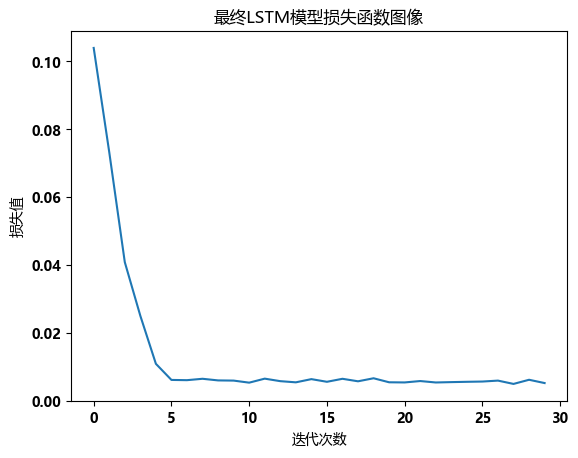

In [14]:
# 绘制训练损失曲线
plt.plot(history.history['loss'])
plt.title('最终LSTM模型损失函数图像')
plt.ylabel('损失值')
plt.xlabel('迭代次数')
plt.show()

In [8]:
# 预测数据准备
# test_pred = fin_model.predict(test_xs)
# test_pred = scaler.inverse_transform(test_pred.reshape(-1,1))
fin_preds = []
for fin in fins:
    test_pred = fin.predict(test_xs)
    test_pred = scaler.inverse_transform(test_pred.reshape(-1,1))
    fin_preds.append(test_pred)
test_x_real = scaler.inverse_transform(test_xs[:, 0, :].reshape(-1,1))
test_y_real = scaler.inverse_transform(test_ys.reshape(-1,1))
test_x_time = data_test_time[:-time_step]
test_y_time = data_test_time[time_step:]

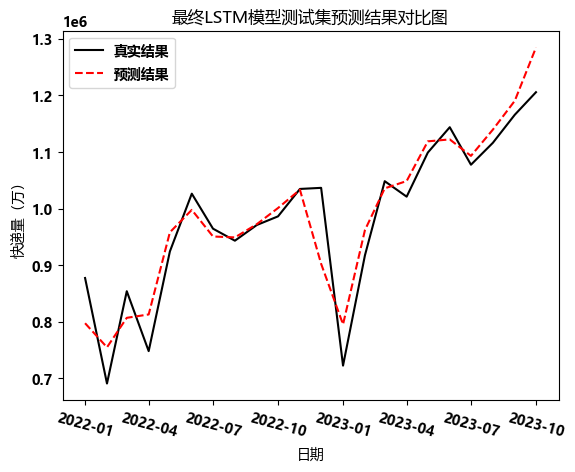

In [17]:
# 绘制预测结果
# plt.plot(test_y_time,test_y_real,color='y',label='Real')
plt.plot(test_x_time,test_x_real,color='k',label='真实结果', linestyle='-')
plt.plot(test_x_time,test_pred,color='r',label='预测结果', linestyle='--')
plt.xlabel('日期')
plt.xticks(rotation=-15)
plt.ylabel('快递量（万）')
plt.title('最终LSTM模型测试集预测结果对比图')
plt.legend()
plt.show()

In [9]:
# 模型误差评估
def get_error(real_y, y_pred):
    mse = np.mean((real_y - y_pred) ** 2)
    rmse = np.sqrt(mse)
    rmsle = np.sqrt(mean_squared_log_error(real_y, y_pred))
    mape = np.mean(np.abs((real_y - y_pred) / real_y)) * 100
    r2 = r2_score(real_y, y_pred)
    errs = [mse, rmse, rmsle, mape, r2]
    # errs = pd.DataFrame(errs, columns=['MSE', 'RMSE', 'RMSLE', 'MAPE', 'R2'])
    return errs

In [37]:
test_err = get_error(test_x_real, test_pred)
test_err = pd.DataFrame(test_err, index=['MSE', 'RMSE', 'RMSLE', 'MAPE', 'R2'], columns=['Testset err'])
test_err = test_err.T

In [10]:
errs = []
for i in range(len(fins)):
    test_pred = fins[i].predict(test_xs)
    test_pred = scaler.inverse_transform(test_pred.reshape(-1,1))
    err = get_error(test_x_real, test_pred)
    errs.append(err)
test_err = pd.DataFrame(errs, columns=['MSE', 'RMSE', 'RMSLE', 'MAPE', 'R2'])

In [11]:
# test_err.to_csv('./final_pred/test_err.csv')
test_err

,MSE,RMSE,RMSLE,MAPE,R2
0,2.625904e+09,51243.577225,0.057431,4.397214,0.858203
1,3.027100e+09,55019.088136,0.060926,4.496847,0.836539
2,2.451985e+09,49517.523863,0.055131,4.109914,0.867594
3,2.432806e+09,49323.478812,0.056003,4.233226,0.868630
4,2.615032e+09,51137.379987,0.056383,4.301919,0.858790
5,3.186961e+09,56453.171326,0.061009,4.615656,0.827906
6,2.576600e+09,50760.224262,0.056106,4.064501,0.860865
7,2.729604e+09,52245.609106,0.058008,4.681650,0.852603
8,2.522381e+09,50223.309778,0.055212,4.213958,0.863793
9,2.544926e+09,50447.259568,0.056843,3.922061,0.862576


In [12]:
fin_model = fins[2]
test_pred = fin_preds[2]

In [18]:
def predict_future(model, num_future_predictions, test, time_step):
    last_known_data = test[-time_step]  # 测试集最后一个时间步长
    # 初始化预测序列
    future_predictions = []
    # 滚动预测
    for _ in range(num_future_predictions):
        # 构建输入数据，将最后一个时间步长作为输入，同时修改数据维度
        input_for_prediction = np.reshape(last_known_data, (1, time_step, 1))
        # 进行预测
        prediction = model.predict(input_for_prediction)
        # 将预测值添加到结果列表
        future_predictions.append(prediction[0])
        # 直接用预测值替换最后一个观测值
        last_known_data = last_known_data[1:]
        last_known_data = np.append(last_known_data, prediction[0], axis=0)
    # future_predictions现在包含了未来num_future_predictions个时间点的预测值
    future_predictions = np.array(future_predictions)
    return future_predictions
# 预测2024与2023剩余数据
future_pred = predict_future(fin_model, 9+time_step, test_xs, time_step)
future_pred = scaler.inverse_transform(future_pred.reshape(-1,1))

In [19]:
fin_x = np.append(test_x,predict_x, axis=0)[:27]
fin_xs = create_dataset(fin_x, time_step)[0]
fin_xs = fin_xs.reshape(fin_xs.shape[0],fin_xs.shape[1],1)

In [20]:
pred = fin_model.predict(fin_xs)
pred = scaler.inverse_transform(pred.reshape(-1,1))

In [21]:
future_pred = predict_future(fin_model, 9+time_step, fin_xs, time_step)
future_pred = scaler.inverse_transform(future_pred.reshape(-1,1))

In [22]:
future_pred_time = np.append(data_test_time,data_predict_time, axis=0)
future_pred_total = np.append(pred,future_pred, axis=0)

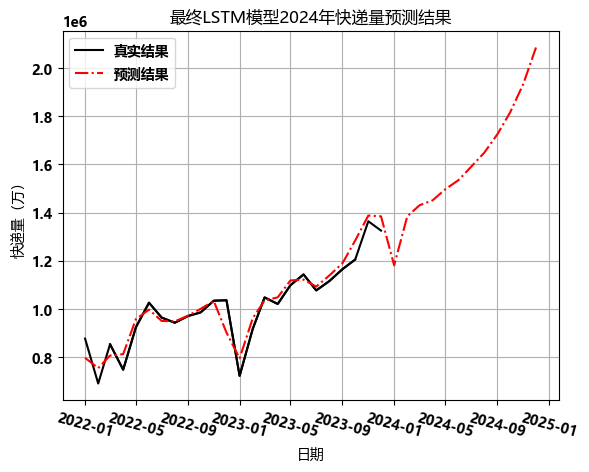

In [25]:
plt.plot(test_y_time,test_y_real,color='k')
plt.plot(test_x_time,test_x_real,color='k',label='真实结果')
plt.plot(future_pred_time,future_pred_total,color='r',label='预测结果', linestyle = '-.')
plt.xlabel('日期')
plt.xticks(rotation=-15)
plt.ylabel('快递量（万）')
plt.title('最终LSTM模型2024年快递量预测结果')
plt.grid()
plt.legend()
plt.show()

In [50]:
#数据记录
future_pred_table = pd.DataFrame(future_pred_total, columns=['Package'],index=future_pred_time)
future_pred_table.to_csv('./final_pred/future_pred_table.csv')